# Sentiment Analysis: Amazon Video Game Reviews

We'll be applying this to a dataset of 210,000 Amazon Video Game reviews.



Just as we did before, we'll use the text of the review to create our _features_, and we'll have 3 possible labels:
- `positive` for all reviews of _4_ and _5_ stars
- `neutral` for all reviews of _3_ stars
- `negative` for all reviews of _2_ stars or below.

The dataset will be at `datasets/video_games_amazon_cleaned.json`. This dataset was taken from [UCSD](http://jmcauley.ucsd.edu/data/amazon/) and was modified to remove fields we don't want/need.

__Resources:__
- [Scikit-learn cheat sheet](http://scikit-learn.org/stable/tutorial/machine_learning_map/index.html)
- [Wiki: Tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)
- [Wiki: Bag of Words](https://en.wikipedia.org/wiki/Bag-of-words_model)

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# This built-in will help us out for Counting words
from collections import Counter

import sklearn

# DictVectorizer will turn a list of dictionaries (BOWs in this case)
# into a Matrix.
from sklearn.feature_extraction import DictVectorizer

# To create test/train splits
from sklearn.model_selection import train_test_split

# Multinomial Naive Bayes
from sklearn.naive_bayes import MultinomialNB

# Neural Networks
from sklearn.neural_network import MLPClassifier

# Random Forests
from sklearn.ensemble import RandomForestClassifier

# Confusion matrix
from sklearn.metrics import confusion_matrix

In [2]:
# This is to stop the barrage of warning messages we'll get later
import warnings; warnings.simplefilter('ignore')

In [3]:
# Create a seed to use later.
seed = 42

In [6]:
# First import your dataset as usual
dataset = "datasets/video_games_amazon_cleaned.json"

# NOTE: We are using read_json() here instead. Recal that JSON format
# looks like lines of Python dictionaries.
# The lines=True option is saying "treat each line as it's own record"
df = pd.read_json(dataset, lines=True)

df.head()

,overall,reviewText
0,1,Installing the game was a struggle (because of...
1,4,If you like rally cars get this game you will ...
2,1,1st shipment received a book instead of the ga...
3,3,"I got this version instead of the PS3 version,..."
4,4,I had Dirt 2 on Xbox 360 and it was an okay ga...


In [13]:
# Let's rename the columns to "text" and "stars" like we did
# in the previous Amazon dataset

# Let's create a dict where index is "current column name" and the
# value is "desired column name"
mapping = {"overall": "stars", "reviewText": "text"}

# Documentation can be found at
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.rename.html
df.rename(mapper=mapping, axis=1, inplace=True)

# Now let's view the first 5 again
df.head()

,stars,text
0,1,Installing the game was a struggle (because of...
1,4,If you like rally cars get this game you will ...
2,1,1st shipment received a book instead of the ga...
3,3,"I got this version instead of the PS3 version,..."
4,4,I had Dirt 2 on Xbox 360 and it was an okay ga...


In [14]:
df.describe()

,stars
count,231780.000000
mean,4.086397
std,1.202330
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


Just like in the previous Amazon dataset, we're seeing the data skewed towards _4_'s and _5_'s

Let's get some visualizations going to help us understand what's going on. again. Below, we're going to group our DataFrame rows by the column we care about, `stars`. 

__Note:__ we're going to get rid of this column soon since we care about `neutral` vs `negative` vs `positive`, not the actual number of stars someone gave.

In [15]:
# Let's get the counts of our columns after we group them by star count
df_star_counts = df.groupby("stars").count()
df_star_counts.head()

,text
stars,
1,14853
2,13663
3,28275
4,54804
5,120185


The text field is just counting how many records we have with that particular number of starts. Again, in this dataset we also have far more _4_'s and _5_'s than anything else.

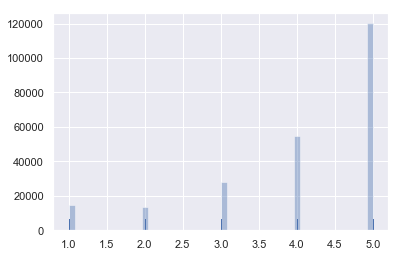

In [16]:
# First, let's just focus on the "text" column and get the values out.
# The list we get here will be the number of examples we have with 1-star,
# with 2-star, and so on
counts = df_star_counts["text"].values

# We'll make an array with the star counts
# So two 1's and four 2's would be: [1, 1, 2, 2, 2, 2]
stars = []
for idx, count in enumerate(counts):
    star_num = idx + 1
    stars += [star_num] * count 

# Here we can make a histogram of the stars. Looks like almost all the ratings are 4's or 5's
sns.distplot(stars, kde=False, rug=True)

In [18]:
# Let's count the total number of examples we have
n_samples = sum(counts)

# Now let's count only the "positive" examples, meaning 4's and 5's
n_positive = sum(counts[3:])

# Compute the ratio of "positive" examples to everything else.
positive_ratio = n_positive / n_samples
print("{:.2f}%".format(positive_ratio * 100))

75.50%


This is a much nicer dataset than the first _amazon_ dataset we used because we would only get around 75% test accuracy if all we did was predict `positive`.

## Our Task
Again, we'll use the [bag of words](https://en.wikipedia.org/wiki/Bag-of-words_model) model to predict `positive`, `neutral` or `negative`.

Afterwards, we'll improve our model by using [Term-frequency-Inverse-Document-Frequency](https://en.wikipedia.org/wiki/Tf%E2%80%93idf). You will do this on your own using `TfidfTransformer`.

Important things to understand about tf-idf:
- tf-idf is a measure per-word per-document (just like the counts are per-word per-document)
- tf-idf increases each time a word is used in a document
- tf-idf inversely weighs that same word if the entire dataset uses that word frequently
- __Intuition__: I really care about a word `w` if `w` is used frequently in my document but not frequently in my dataset.

_Document_ here means each example of text.

In [33]:
# We need to preprocess our data. Let's build our counts of words.
# TODO: Implement this function, you can copy it from previous assignment.
def bag_of_words(text):
    """
    TODO: 
    1. Lowercase everything in the text
    2. Replace all punctuation except exclamation point & apostrophe with space
    HINT: use text.replace() function. It's called "string replacement"
    3. Replace all apostrophes with empty strings
    4. Replace all "!" with  " ! ". This will treat each "!" as a word which will
    help with our BOW model
    6. Split up the text into words, and make a list called "words" that holds all the words
    including "!"
    7. Finally, return Counter(words), which will be a dictionary with counts of the occurence
    of each word
    """
    punctuation = [".", ",", "(", ")", ":", ";", '"', "\n", "\\", "\/", "&", "+", "-"] # HINT: filter these out
    words = text.split(" ")
    return Counter(keep_words)


In [21]:
%%time
text_vals = df["text"].values

# Apply the bag_of_words to the functions and store those in a list called bows.
bows = []
for text in text_vals:
    bow = bag_of_words(text)
    bows.append(bow)

CPU times: user 17.8 s, sys: 1.63 s, total: 19.5 s
Wall time: 20 s


In [28]:
# So, now we have the bag of words for ALL text in our dataset. Let's count up occurrences
# for each word in the dataset. Later, we'll filter out the infrequence words we don't want.
word_occurrences = Counter()

for bow in bows:
    word_occurrences.update(bow)

In [36]:
# Create the vector y, which has our labels
y_stars = df["stars"].values
y = []

for stars in y_stars:
    if stars >= 4:
        y.append("positive")
    elif stars == 3:
        y.append("neutral")
    else:
        y.append("negative")

y = np.array(y)

In [37]:
# We'll make a helper function that accepts min_occurence and stop_words
# and produces a new vocabulary
def create_vocab(min_occurrence, stop_words):
    # Now, let's filter out the words that have < 30 occurences
    vocab = set()
    removed_vocab = set()

    for word, count in word_occurrences.items():
        if count >= min_occurrence and word not in stop_words:
            vocab.add(word)
        else:
            removed_vocab.add(word)
            
    return vocab, removed_vocab

In [38]:
# Now, we create a bag_of_words_using_vocab function that does the same thing as
# bag_of_words above except we remove any words that are not in the vocab set
def bag_of_words_using_vocab(text, vocabulary=set()):
    bow = bag_of_words(text)
    words = list(bow.keys())
    for word in words:
        if word not in vocabulary:
            bow.pop(word)
    
    return bow

In [39]:
# Here we'll create a helper function to take care of making new data splits
def use_new_vocab(vocabulary):
    new_bows = []

    for text in text_vals:
        # Use bag_of_words_using_vocab with the vocabulary
        new_bow = bag_of_words_using_vocab(text, vocabulary=vocabulary)
        new_bows.append(new_bow)
    
    # Now, creater vectors from these dictionaries
    X = DictVectorizer().fit_transform(new_bows)
    
    # Create test/train splits
    train_X, test_X, train_y, test_y = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=seed)
    return (train_X, test_X, train_y, test_y)

## TODO: Train Estimators

Use `create_vocab()` and `use_new_vocab` to create `train_X, test_X, train_y, test_y`, which are the training and test sets generated from the updated vocabulary words. Do __at least__ 3 trials here.

Apply these 2 algorithms:
- [MultinomialNB](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)
- [Random Forest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

__NOTE:__ Use cross-validation only for models that don't take a long time to train. If you're training models for > 5 mins, tweak things around so you aren't doing that. Remember, we're trying to beat 75% accuracy on this dataset.

In [41]:
%%time
# Trial 1
min_occurence = 1  # TODO: Change this to a big number
stop_words = []  # TODO: Change this to have some stop-words

vocab, removed_vocab = create_vocab(min_occurence, stop_words)
print(len(vocab))
print(len(removed_vocab))

# Create test/train splits
train_X, test_X, train_y, test_y = use_new_vocab(vocab)

17819
261013


In [43]:
%%time
mnb = MultinomialNB()
mnb.fit(train_X, train_y)

mb_train_acc = mnb.score(train_X, train_y)
mb_test_acc = mnb.score(test_X, test_y)

Train accuracy: 76.97%
Test accuracy: 75.53%
CPU times: user 449 ms, sys: 27.6 ms, total: 476 ms
Wall time: 478 ms


In [ ]:
print("MB Train accuracy: {:.2f}%".format(mb_train_acc * 100))
print("MB Test accuracy: {:.2f}%".format(mb_train_acc * 100))

In [44]:
%%time
rf = RandomForestClassifier(random_state=seed)
rf.fit(train_X, train_y)

rf_train_acc = rf.score(train_X, train_y)
rf_test_acc = rf.score(test_X, test_y)

Train accuracy: 99.06%
Test accuracy: 76.72%
CPU times: user 2min 23s, sys: 1.01 s, total: 2min 24s
Wall time: 2min 26s


In [ ]:
print("RF Train accuracy: {:.2f}%".format(rf_train_acc * 100))
print("RF Test accuracy: {:.2f}%".format(rf_test_acc * 100))

In [45]:
%%time
# Trial 2
min_occurence = 1  # TODO: Change this to a big number
stop_words = []  # TODO: Change this to have some stop-words

vocab, removed_vocab = create_vocab(min_occurence, stop_words)
print(len(vocab))
print(len(removed_vocab))

# Create test/train splits
train_X, test_X, train_y, test_y = use_new_vocab(vocab)

8680
270152
CPU times: user 50.7 s, sys: 9.35 s, total: 1min
Wall time: 1min 1s


In [46]:
%%time
mnb = MultinomialNB()
mnb.fit(train_X, train_y)

mb_train_acc = mnb.score(train_X, train_y)
mb_test_acc = mnb.score(test_X, test_y)

CPU times: user 442 ms, sys: 40.5 ms, total: 483 ms
Wall time: 490 ms


In [47]:
print("MB Train accuracy: {:.2f}%".format(mb_train_acc * 100))
print("MB Test accuracy: {:.2f}%".format(mb_train_acc * 100))

MB Train accuracy: 76.15%
MB Test accuracy: 76.15%


In [48]:
%%time
rf = RandomForestClassifier(random_state=seed)
rf.fit(train_X, train_y)

rf_train_acc = rf.score(train_X, train_y)
rf_test_acc = rf.score(test_X, test_y)

CPU times: user 2min 37s, sys: 1.11 s, total: 2min 38s
Wall time: 2min 40s


In [49]:
print("RF Train accuracy: {:.2f}%".format(rf_train_acc * 100))
print("RF Test accuracy: {:.2f}%".format(rf_test_acc * 100))

RF Train accuracy: 99.08%
RF Test accuracy: 76.67%


In [50]:
%%time
# Trial 3
min_occurence = 1  # TODO: Change this to a big number
stop_words = []  # TODO: Change this to have some stop-words

vocab, removed_vocab = create_vocab(min_occurence, stop_words)
print(len(vocab))
print(len(removed_vocab))

# Create test/train splits
train_X, test_X, train_y, test_y = use_new_vocab(vocab)

5124
273708
CPU times: user 47.1 s, sys: 6.91 s, total: 54.1 s
Wall time: 55 s


In [51]:
%%time
mnb = MultinomialNB()
mnb.fit(train_X, train_y)

mb_train_acc = mnb.score(train_X, train_y)
mb_test_acc = mnb.score(test_X, test_y)

CPU times: user 416 ms, sys: 27 ms, total: 443 ms
Wall time: 447 ms


In [52]:
print("MB Train accuracy: {:.2f}%".format(mb_train_acc * 100))
print("MB Test accuracy: {:.2f}%".format(mb_train_acc * 100))

MB Train accuracy: 75.71%
MB Test accuracy: 75.71%


In [53]:
%%time
rf = RandomForestClassifier(random_state=seed)
rf.fit(train_X, train_y)

rf_train_acc = rf.score(train_X, train_y)
rf_test_acc = rf.score(test_X, test_y)

CPU times: user 2min 44s, sys: 1.02 s, total: 2min 45s
Wall time: 2min 49s


In [54]:
print("RF Train accuracy: {:.2f}%".format(rf_train_acc * 100))
print("RF Test accuracy: {:.2f}%".format(rf_test_acc * 100))

RF Train accuracy: 99.12%
RF Test accuracy: 76.74%


## TODO: Evaluation

Evaluate how well we did using Confusion matrices and accuracies

## TODO: Improve the Model

Try these approaches to improve your model:
- Try changing the minimum occurences
- Try different stop-words
- Use CV for the faster models
- Try [SGDClassifier](http://scikit-learn.org/stable/modules/sgd.html#tips-on-practical-use) and make sure to use `StandardScaler` here just like this document shows.

__GOAL:__ See how high you can get your accuracy. I managed to get _76.7_% accuracy with very little tuning.

## TODO: Use Tf-Idf
Use the [TfidfTransformer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html) on the output from the `DictVectorizer`. This will change our values from being `counts` of a word in a document to being the `tf-idf` value for that word in that document.

__GOAL:__ Get 80-85% accuracy. Students with the top 3 accuracies will get a prize.